In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
cases = ['ASD',
        'SZ',
        'BIP',
        'ADHD',
        'DEL15q11_2',
        'DEL22q11_2',
        'DUP22q11_2',
        'DEL16p11_2',
        'DUP16p11_2',
        'DEL1q21_1',
        'DUP1q21_1']

cases = ['DEL15q11_2',
        'DUP1q21_1',
        'DEL1q21_1',
        'DUP22q11_2',
        'DUP16p11_2',
        'DEL16p11_2',
        'DEL22q11_2',
        'ADHD',
        'ASD',
        'SZ',
        'BIP',]

labels = ['DEL 15q11.2',
    'DUP 1q21.1',
        'DEL 1q21.1',
        'DUP 22q11.2',
        'DUP 16p11.2',
        'DEL 16p11.2',
        'DEL 22q11.2',
        'ADHD',
        'ASD',
        'SZ',
        'BIP',]

p_single = '../results_paper/baseline/mlp/'
p_mtl = '../results_paper/mtl/mlp/'

# Load Data

In [3]:
# Single Task
st_data_conn = []
for case in cases:
    folds_conn = []
    for fold in range(5):
        # Connectomes
        p_parent = os.path.join(p_single, f"{case}/fold_{fold}")
        file = [f for f in os.listdir(p_parent) if f[-4:]=='.csv'][0]
        folds_conn.append(pd.read_csv(os.path.join(p_parent,file),index_col=0,header=[0,1])[case])

    st_data_conn.append(folds_conn)

st_data_conn = dict(zip(cases,st_data_conn))

In [4]:
# Multi-task
mtl_data_conn = []
for fold in range(5):
    # Connectomes
    p_parent = os.path.join(p_mtl, f"fold_{fold}")
    file = [f for f in os.listdir(p_parent) if f[-4:]=='.csv'][0]
    mtl_data_conn.append(pd.read_csv(os.path.join(p_parent,file),index_col=0,header=[0,1]))


# Get Accuracy

In [5]:
# Single Task
st_acc_conn = []
st_acc_conn_std = []
for case in cases:
    # Connectomes
    vals = [st_data_conn[case][fold]['Accuracy/test'].iloc[-1] for fold in range(5)]
    st_acc_conn.append(np.mean(vals))
    st_acc_conn_std.append(np.std(vals))


st_acc_conn = pd.Series(st_acc_conn,index=cases)
st_acc_conn_std = pd.Series(st_acc_conn_std,index=cases)

In [6]:
# Multi-task
mtl_acc_conn = []
for fold in range(5):
    # Connectomes
    df = mtl_data_conn[fold].transpose().reset_index()
    df = df[df['level_1']=='Accuracy/test'].set_index('level_0')[99]
    mtl_acc_conn.append(df)
    
mtl_acc_conn_std = pd.concat(mtl_acc_conn,axis=1).std(axis=1)
mtl_acc_conn = pd.concat(mtl_acc_conn,axis=1).mean(axis=1)

# Tables

In [7]:
# Connectomes
df_conn = pd.concat([st_acc_conn,mtl_acc_conn,st_acc_conn_std,mtl_acc_conn_std],axis=1)
df_conn.columns = ['ST','MTL','ST_std','MTL_std']
df_conn

,ST,MTL,ST_std,MTL_std
DEL15q11_2,54.378630,57.735192,4.057667,8.362006
DUP1q21_1,53.214286,52.500000,22.314999,7.533937
DEL1q21_1,70.000000,46.000000,14.142136,23.021729
DUP22q11_2,41.388889,47.222222,13.391079,24.689429
DUP16p11_2,64.285714,58.571429,4.517540,9.313146
DEL16p11_2,73.461538,64.230769,7.730674,8.113470
DEL22q11_2,84.967320,74.313725,8.571815,9.154994
ADHD,55.206897,59.197901,2.576093,3.358597
ASD,61.085219,59.389846,2.463449,5.414320
SZ,75.709892,74.147392,1.652202,3.962774


In [8]:
df_conn.mean()

ST         64.791862
MTL        61.642413
ST_std      7.676434
MTL_std     9.714192
dtype: float64

# Plots

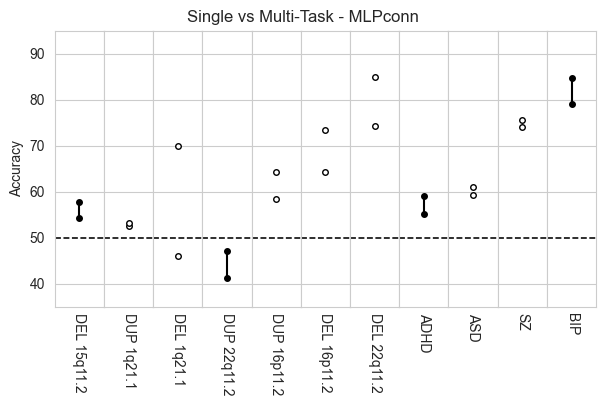

In [10]:
###############
# CONNECTOMES #
###############
title = 'Single vs Multi-Task - MLPconn'
fig,ax = plt.subplots(1,len(cases),figsize=(6,4),sharey=True,sharex=True)
plt.yticks([40,50,60,70,80,90])
sns.set_style('whitegrid')
colors = ['black','darkorchid','red','orange','dodgerblue','forestgreen']

for j,case in enumerate(cases):
    st_acc = df_conn.loc[case]['ST']
    mtl_acc = df_conn.loc[case]['MTL']
    if st_acc > mtl_acc:
        mfc = 'white'
        ls =''
    else:
        mfc = colors[0]
        ls = '-'

    ax[j].plot(5,mtl_acc,marker='o',color=colors[0],ms=4,markerfacecolor=mfc)
    ax[j].plot(5,st_acc,marker='o',color=colors[0],ms=4,markerfacecolor=mfc)
    ax[j].plot((5,5),(st_acc,mtl_acc),color=colors[0],ls=ls)
    ax[j].set_xticklabels([])
    ax[j].set_xticks([])
    ax[j].set_xlabel(labels[j],rotation=270)

    lines = ax[j].get_ygridlines()
    b = lines[1]
    b.set_color('black')
    b.set_linewidth(1.15)
    b.set_linestyle('--')

ax[0].set_ylabel('Accuracy')
plt.suptitle(title)
plt.ylim(35,95)
plt.tight_layout(pad=0.5)
plt.subplots_adjust(wspace=0)
plt.savefig(os.path.join('/Users/harveyaa/Documents/masters/neuropsych_mtl/MTL/results_paper/mtl/','figures/st_vs_mtl.png'),dpi=300)